In [33]:
%matplotlib inline

In [34]:
import numpy as np
from nighres import io
import pandas as pd
import gdist
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from statsmodels.stats.multitest import multipletests

In [35]:
df = pd.read_csv('/home/julia/workspace/rodent_gradients/regions.csv')

In [36]:
mesh = io.load_mesh('/home/julia/data/gradients/atlas/allen_api/regions/annot_finest.vtk')
cortex = np.where(mesh['data']!=0)[0]

In [37]:
gradients = io.load_mesh('/home/julia/data/gradients/results/embedding_vol/embed_sampled_mesh.vtk')

### Make surface masks of the primary areas

In [7]:
for a in ['AUDp', 'VISp', 'MOp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    new_mesh = {'points':mesh['points'], 'faces':mesh['faces']}
    new_data = np.zeros_like(mesh['data'])
    new_data[np.round(mesh['data'])==idx] = 1
    new_mesh['data']=new_data
    io.save_mesh('/home/julia/data/gradients/results/distance/%s.vtk'%a, new_mesh)

In [8]:
new_mesh = {'points':mesh['points'], 'faces':mesh['faces']}
new_data = np.zeros_like(mesh['data'])

for a in ['SSp-n','SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    new_data[np.round(mesh['data'])==idx] = 1
    
new_mesh['data']=new_data
io.save_mesh('/home/julia/data/gradients/results/distance/SSp.vtk', new_mesh)

### Calculate center of mass of primary regions, combine somatosensory regions and calculate distance

In [38]:
patches = np.zeros_like(mesh['data'])
for a in ['SSp-bfd', 'SSp-m']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches[np.round(mesh['data'])==idx] = 1
sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
patch_a = np.hstack((np.where([sub_patches[:,1]==1])[1], np.where([sub_patches[:,1]==2])[1]))
patch_b = np.hstack((np.where([sub_patches[:,1]==3])[1], np.where([sub_patches[:,1]==4])[1]))

for patch in [patch_a, patch_b]:
    x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
    y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
    z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
    center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
    center_data[center] = 1

for a in ['VISp', 'AUDp']:
    idx = df.loc[df['acronym'] == a, 'id'].values[0]
    patches = np.zeros_like(mesh['data'])
    patches[np.round(mesh['data'])==idx] = 1
    sub_patches = subcluster_graph(mesh['points'],  mesh['faces'], patches)
    patch_a = np.where([sub_patches[:,1]==1])[1]
    patch_b = np.where([sub_patches[:,1]==2])[1]

    for patch in [patch_a, patch_b]:
        x = mesh['points'][patch][:,0].min() + ((mesh['points'][patch][:,0].max() - mesh['points'][patch][:,0].min())/2)
        y = mesh['points'][patch][:,1].min() + ((mesh['points'][patch][:,1].max() - mesh['points'][patch][:,1].min())/2)
        z = mesh['points'][patch][:,2].min() + ((mesh['points'][patch][:,2].max() - mesh['points'][patch][:,2].min())/2)
        center = np.argmin(np.sqrt(np.sum((mesh['points']-[x,y,z])**2, axis=1)))
        center_data[center] = 1

io.save_mesh('/home/julia/data/gradients/results/distance/type4_centers.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':center_data})

In [39]:
center_data = io.load_mesh('/home/julia/data/gradients/results/distance/type4_centers.vtk')['data']

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2455: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2458: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [44]:
source = np.where(center_data==1)[0]
dist = gdist.compute_gdist(np.array(mesh['points'], dtype=np.float64), 
                           np.array(mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros_like(mesh['data'])
dist_mesh[cortex] = dist[:,np.newaxis]
io.save_mesh('/home/julia/data/gradients/results/distance/type4_center_dist.vtk',
             {'points':mesh['points'], 'faces':mesh['faces'], 'data':dist_mesh})

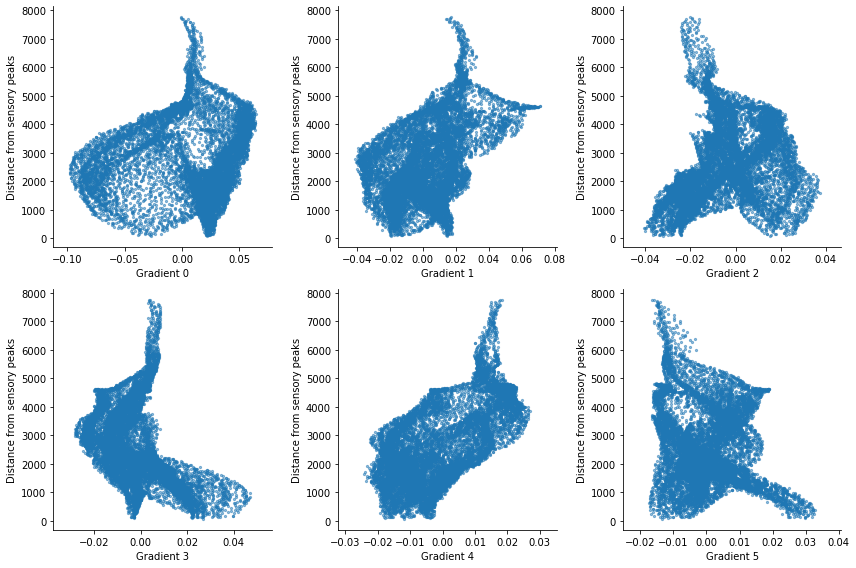

In [45]:
dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_center_dist.vtk')

fig = plt.figure(figsize=(12, 8))
for g in range(6):
    fig.add_subplot(2,3,(g+1))
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    plt.scatter(gradients['data'][:,g][mask], dist['data'][:,0][mask], alpha=0.5, s=5)
    plt.xlabel('Gradient %s'%g)
    plt.ylabel('Distance from sensory peaks')
    sns.despine()
    plt.tight_layout()

In [46]:
r_values = []
p_values = []
for g in range(6):
    dist = io.load_mesh('/home/julia/data/gradients/results/distance/type4_center_dist.vtk')
    mask = np.zeros(dist['data'].shape[0], dtype=np.int16)
    mask[gradients['data'][:,g]!=0]=1
    mask[dist['data'][:,0]==0]=0
    mask=np.where(mask==1)[0]
    r, p = stats.spearmanr(gradients['data'][:,g][mask], dist['data'][:,0][mask])
    r_values.append(r)
    p_values.append(p)

In [47]:
reject_0, p_corr, _, _ = multipletests(p_values, alpha=0.01, method='fdr_bh')
for g in range(6):
    if reject_0[g] == True:
        print('Gradient %i'%g, "r=%f"%r_values[g], 'p_corr=%f'%p_corr[g])

Gradient 0 r=0.028031 p_corr=0.002574
Gradient 1 r=0.427129 p_corr=0.000000
Gradient 2 r=0.329298 p_corr=0.000000
Gradient 3 r=-0.405659 p_corr=0.000000
Gradient 4 r=0.597285 p_corr=0.000000
Gradient 5 r=-0.104855 p_corr=0.000000
